In [2]:
import pandas as pd
import numpy as np
import scipy.sparse as sps
from tqdm import tqdm
import math
from random import sample 
import matplotlib.pyplot as plt

/Users/a.bogoslavskaya/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# def mapping(col):
#     return dict(zip(col.unique(), range(col.nunique())))
# good_foreign_id_to_item_id = mapping(data["good_foreign_id"])
# data["item_id"] = data["good_foreign_id"].map(good_foreign_id_to_item_id)
# data["basket_id"] = data["order_id"].map(mapping(data["order_id"]))

Data Load + EDA: 

In [5]:
df = pd.read_csv('vkusvill_data_20_april.csv')

In [6]:
df.head()

,ts,order_id,good_foreign_id
0,2024-04-26 13:43:53.044061,300652819016,83595
1,2024-04-25 12:02:21.705166,300652801623,34835
2,2024-04-27 11:52:32.638244,300652829735,70127
3,2024-04-28 21:25:05.313815,300652850222,31501
4,2024-04-28 15:00:10.870397,300652845460,85447


In [7]:
df['date'] = df.ts.apply(lambda x: x[:10])

In [8]:
gp = pd.DataFrame(df.groupby(['order_id']).agg(list).good_foreign_id).reset_index()

gp.good_foreign_id[gp.good_foreign_id.apply(lambda x: len(x)) == 1] # baskets with a few products - not suitable for the test

10       [83349]
75       [30144]
83       [58467]
85       [54714]
103      [78565]
          ...   
85138    [43762]
85139    [83512]
85156    [15495]
85176    [77072]
85180    [65235]
Name: good_foreign_id, Length: 2292, dtype: object

In [9]:
indexes_to_remove = gp.good_foreign_id[gp.good_foreign_id.apply(lambda x: len(x)) == 1].index.to_list()

In [10]:
df = df.drop(index = indexes_to_remove).reset_index(drop = True)

In [11]:
df.head()

,ts,order_id,good_foreign_id,date
0,2024-04-26 13:43:53.044061,300652819016,83595,2024-04-26
1,2024-04-25 12:02:21.705166,300652801623,34835,2024-04-25
2,2024-04-27 11:52:32.638244,300652829735,70127,2024-04-27
3,2024-04-28 21:25:05.313815,300652850222,31501,2024-04-28
4,2024-04-28 15:00:10.870397,300652845460,85447,2024-04-28


In [12]:
df.shape

(626448, 4)

Splitting the data: the train set contains 80% of the items in each basket, and the test set contains the remaining 20%

In [13]:
def split_train_test(group, time_threshold):
    
    train = group[group['date'] <= time_threshold]
    test = group[group['date'] > time_threshold]
    
#     # For test, masking 20% of items
#     test_masked = test.copy()
#     test_masked['masked'] = np.random.choice([True, False], size=len(test), p=[0.2, 0.8])
#     test_masked = test_masked[test_masked['masked']]
    
    return train,test

In [14]:
time_threshold = '2024-04-28'

train_data, test_data = zip(*df.groupby('order_id').apply(split_train_test, 
                                                                 time_threshold=time_threshold))

train_data = pd.concat(train_data)
test_data = pd.concat(test_data)

In [15]:
train_data

,ts,order_id,good_foreign_id,date
27980,2024-04-20 00:02:54.604473,300652732887,38472,2024-04-20
94829,2024-04-20 00:02:54.604473,300652732887,65528,2024-04-20
118020,2024-04-20 00:02:54.604473,300652732887,22260,2024-04-20
162366,2024-04-20 00:02:54.604473,300652732887,15353,2024-04-20
274471,2024-04-20 00:02:54.604473,300652732887,30718,2024-04-20
...,...,...,...,...
330006,2024-04-28 23:58:09.225188,300652850776,67825,2024-04-28
546571,2024-04-28 23:58:09.225188,300652850776,647,2024-04-28
605166,2024-04-28 23:58:09.225188,300652850776,74814,2024-04-28
100458,2024-04-28 23:59:46.796444,300652850780,647,2024-04-28


For test data creating a copy() with 20% of masked values to score predictions for further: 

In [16]:
test_data.head()

,ts,order_id,good_foreign_id,date
1705,2024-04-29 00:00:14.840611,300652850781,647,2024-04-29
140544,2024-04-29 00:00:14.840611,300652850781,73255,2024-04-29
211214,2024-04-29 00:00:14.840611,300652850781,42672,2024-04-29
52058,2024-04-29 00:02:10.027272,300652850783,33142,2024-04-29
62197,2024-04-29 00:02:10.027272,300652850783,72133,2024-04-29


In [17]:
grouped_items = pd.DataFrame(test_data.groupby(['order_id', 'date']).agg(list).good_foreign_id).reset_index()

In [18]:
grouped_items.head(3)

,order_id,date,good_foreign_id
0,300652850781,2024-04-29,"[647, 73255, 42672]"
1,300652850783,2024-04-29,"[33142, 72133, 647, 59318]"
2,300652850784,2024-04-29,"[647, 47115, 1642, 69937]"


In [19]:
grouped_items['lists_len'] = grouped_items.good_foreign_id.apply(lambda x: len(x))

In [20]:
grouped_items['num_to_mask'] = grouped_items['lists_len'].apply(lambda x: math.ceil(x * 0.2))
grouped_items

,order_id,date,good_foreign_id,lists_len,num_to_mask
0,300652850781,2024-04-29,"[647, 73255, 42672]",3,1
1,300652850783,2024-04-29,"[33142, 72133, 647, 59318]",4,1
2,300652850784,2024-04-29,"[647, 47115, 1642, 69937]",4,1
3,300652850787,2024-04-29,"[63727, 18291, 34804, 647, 36871, 63032, 48473...",10,2
4,300652850789,2024-04-29,"[647, 16591, 73541, 83219, 68678, 85386, 89167]",7,2
...,...,...,...,...,...
6821,300652862092,2024-04-30,"[61013, 23025, 52515, 73783, 25290, 647, 27834]",7,2
6822,300652862093,2024-04-30,"[33572, 32680, 647, 20038, 30155, 22297]",6,2
6823,300652862094,2024-04-30,"[173, 65511, 74946, 60900, 647]",5,1
6824,300652862095,2024-04-30,"[51223, 22659, 77201, 67270, 647, 75440]",6,2


In [21]:
def mask_values(lst, num):
    curr_lst = lst.copy()  
    new_list = sample(curr_lst, len(curr_lst) - num)
    return new_list

In [22]:
grouped_items['lists_to_pred'] = grouped_items.apply(lambda row: mask_values(row['good_foreign_id'], 
                                                                             row['num_to_mask']), axis=1)

In [23]:
grouped_items_to_test = grouped_items.copy()

In [24]:
grouped_items.head(3)

,order_id,date,good_foreign_id,lists_len,num_to_mask,lists_to_pred
0,300652850781,2024-04-29,"[647, 73255, 42672]",3,1,"[647, 73255]"
1,300652850783,2024-04-29,"[33142, 72133, 647, 59318]",4,1,"[647, 72133, 59318]"
2,300652850784,2024-04-29,"[647, 47115, 1642, 69937]",4,1,"[647, 47115, 1642]"


In [25]:
grouped_items = grouped_items[['order_id', 'date', 'good_foreign_id', 'lists_len', 'num_to_mask',
       'lists_to_pred']].explode('lists_to_pred')

grouped_items.shape

(36539, 6)

In [26]:
# grouped_items.groupby(['order_id']).agg(list).lists_to_pred

In [27]:
masked_data = grouped_items[['order_id','date', 
                             'lists_to_pred']].rename({'lists_to_pred': 'good_foreign_id'}, axis = 1)

In [28]:
masked_data

,order_id,date,good_foreign_id
0,300652850781,2024-04-29,647
0,300652850781,2024-04-29,73255
1,300652850783,2024-04-29,647
1,300652850783,2024-04-29,72133
1,300652850783,2024-04-29,59318
...,...,...,...
6825,300652862096,2024-04-30,14526
6825,300652862096,2024-04-30,85011
6825,300652862096,2024-04-30,43207
6825,300652862096,2024-04-30,22658


Creating the mappings from 'order_id' and 'item_id' to unique integers:

In [29]:
user2idx = {v: k for k, v in enumerate(train_data.order_id.unique())}
item2idx = {v: k for k, v in enumerate(train_data.good_foreign_id.unique())}

idx2user = {k:v for v, k in user2idx.items()}
idx2item = {k:v for v, k in item2idx.items()}

train_data['order_id'] = train_data.order_id.apply(lambda x: user2idx[x])
train_data['item_id'] = train_data.good_foreign_id.apply(lambda x: item2idx[x])

Creating sparce matrix: 

In [30]:
matrix = sps.coo_matrix(
    (np.ones(train_data.shape[0]), (train_data['order_id'], train_data['item_id'])),
    shape=(len(user2idx), len(item2idx)),
)

In [31]:
matrix.shape

(78358, 10452)

Fitting EASE, RecBol realization: 

In [32]:
def fit_ease(X, reg_weight=100):
    
 # gram matrix
    G = X.T @ X

    # add reg to diagonal
    G += reg_weight * sps.identity(G.shape[0])

    # convert to dense because inverse will be dense
    G = G.todense()

    # invert. this takes most of the time
    P = np.linalg.inv(G)
    B = P / (-np.diag(P))
    # zero out diag
    np.fill_diagonal(B, 0.)
    
    return B

In [33]:
w = fit_ease(matrix)

In [34]:
w

matrix([[ 0.00000000e+00,  1.10621448e-02,  1.05253960e-01, ...,
         -2.54472793e-05, -3.45571211e-05, -4.85437743e-05],
        [ 1.22923529e-02,  0.00000000e+00,  4.81064028e-03, ...,
          1.19494612e-05,  3.36763793e-06,  5.15738453e-06],
        [ 9.99114942e-02,  4.10945481e-03,  0.00000000e+00, ...,
          3.34316795e-05,  1.43358188e-05,  1.73284637e-05],
        ...,
        [-3.76501963e-05,  1.59103059e-05,  5.21083204e-05, ...,
          0.00000000e+00,  1.81904063e-06,  2.63985277e-06],
        [-5.11418581e-05,  4.48506414e-06,  2.23503559e-05, ...,
          1.81951424e-06,  0.00000000e+00,  1.35654836e-06],
        [-7.18179342e-05,  6.86646483e-06,  2.70073779e-05, ...,
          2.63969157e-06,  1.35611244e-06,  0.00000000e+00]])

Getting user-interaction vector: 

In [35]:
# df.groupby(['order_id'])['item_id'].agg([('basket_id', list)]).reset_index()

def get_user_vector(basket):
    vector = np.zeros(len(item2idx))
    for item in basket:
        if item in item2idx:
            vector[item2idx[item]] = 1
    return vector

In [36]:
pred = masked_data.groupby(['order_id'])['good_foreign_id'].agg([('basket', list)]).reset_index()
pred['vector'] = pred.basket.apply(lambda x: get_user_vector(x))
pred.head()

,order_id,basket,vector
0,300652850781,"[647, 73255]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,300652850783,"[647, 72133, 59318]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,300652850784,"[647, 47115, 1642]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,300652850787,"[64579, 63727, 36871, 48473, 647, 18291, 42530...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,300652850789,"[89167, 83219, 85386, 647, 73541]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [37]:
scores = []
recs_for_user = []
batch = []

In [38]:
for idx, row in tqdm(pred.iterrows(), total=pred.shape[0]):
    vector = row.vector
    batch.append(vector)
    
    if len(batch) > 10000:
        batch = np.array(batch)
        user_scores = batch.dot(w)
        user_scores = np.argsort(-user_scores)[:, :200]
        for i in range(len(user_scores)):
            recs_for_user.append(user_scores[i].tolist())
        batch = []

batch = np.array(batch)
user_scores = batch.dot(w)
user_scores = np.argsort(-user_scores)[:, :200]
for i in range(len(user_scores)):
    recs_for_user.append(user_scores[i].tolist())

100%|████████████████████████████████████| 6826/6826 [00:00<00:00, 41035.70it/s]


In [39]:
def get_decoded_recommendations(x):
    
    recs = []
    consumed = [item2idx[t] for t in x.basket if t in item2idx]
    for el in x.recs[0]:
        recs.append(idx2item[el])
        if len(recs) == 20:
            break
            
    return recs

In [40]:
pred['recs'] = recs_for_user

In [41]:
pred['preds'] = pred.apply(lambda x: get_decoded_recommendations(x), axis=1)

Validation: 

First option: usinf calassic @ k precision and recall 

In [42]:
grouped_items_to_test.head(3)

,order_id,date,good_foreign_id,lists_len,num_to_mask,lists_to_pred
0,300652850781,2024-04-29,"[647, 73255, 42672]",3,1,"[647, 73255]"
1,300652850783,2024-04-29,"[33142, 72133, 647, 59318]",4,1,"[647, 72133, 59318]"
2,300652850784,2024-04-29,"[647, 47115, 1642, 69937]",4,1,"[647, 47115, 1642]"


In [134]:
evaluation_df = grouped_items_to_test[['order_id','good_foreign_id', 'num_to_mask']
                             ].merge(pred)

In [135]:
assert evaluation_df.shape[0] == grouped_items_to_test.shape[0]

In [136]:
# evaluation_df

In [137]:
evaluation_df = evaluation_df.rename({'good_foreign_id': 'original_basket', 
                     'basket': 'masked_basket'}, axis = 1).reset_index(drop = True)

In [138]:
evaluation_df_data_tables = evaluation_df.copy()

In [139]:
evaluation_df.head()

,order_id,original_basket,num_to_mask,masked_basket,vector,recs,preds
0,300652850781,"[647, 73255, 42672]",1,"[647, 73255]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[9, 93, 67, 151, 480, 3030, 546, 80, 1404, 48...","[647, 731, 173, 76719, 76709, 61986, 49623, 33..."
1,300652850783,"[33142, 72133, 647, 59318]",1,"[647, 72133, 59318]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[9, 1117, 6402, 67, 1770, 546, 409, 1803, 326...","[647, 59310, 79165, 173, 24910, 49623, 185, 56..."
2,300652850784,"[647, 47115, 1642, 69937]",1,"[647, 47115, 1642]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[9, 67, 93, 122, 407, 410, 546, 966, 532, 419...","[647, 173, 731, 605, 14526, 17525, 49623, 3629..."
3,300652850787,"[63727, 18291, 34804, 647, 36871, 63032, 48473...",2,"[64579, 63727, 36871, 48473, 647, 18291, 42530...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[9, 93, 546, 1910, 497, 1918, 1909, 67, 206, ...","[647, 731, 49623, 18518, 19434, 17823, 75717, ..."
4,300652850789,"[647, 16591, 73541, 83219, 68678, 85386, 89167]",2,"[89167, 83219, 85386, 647, 73541]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[9, 878, 93, 667, 67, 307, 1098, 966, 206, 20...","[647, 488, 731, 16306, 173, 47467, 273, 36296,..."


In [140]:
def dcg_at_k(preds, k):
    dcg = 0.0
    for i in range(min(k, len(preds))):
        rel = 1 if preds[i] in original_basket else 0  # Relevance is 1 if item is in original basket, else 0
        dcg += (2 ** rel - 1) / np.log2(i + 2)
    return dcg

def ndcg_at_k(preds, k):
    idcg = dcg_at_k(sorted(original_basket, reverse=True), k)  # Ideal DCG
    dcg = dcg_at_k(preds, k)  # DCG
    if not idcg:
        return 0.0
    return dcg / idcg

In [ ]:
k = 5
ndcg_at_k(preds, k)

In [114]:
def precision_recall_at_k(masked_basket, preds, original_basket):
    
#     precision = []
#     recall = []
#     masked_and_preds = masked_basket.copy()
#     for k in range(1, len(preds) + 1):
#         masked_and_preds.extend(preds[:k])  # adding k predictions to masked basket
#         intersection = len(set(masked_and_preds).intersection(set(original_basket)))
#         precision.append(intersection / len(masked_and_preds))
#         recall.append(intersection / len(original_basket))
#     return precision, recall

    precision = []
    recall = []
    masked_and_preds = masked_basket.copy()
    k = 0
    while k < len(preds) and len(masked_and_preds):
        # check if prediction is already in masked_basket
        if preds[k] not in masked_and_preds:
            masked_and_preds.append(preds[k])  # Add prediction to masked basket only if it's not already there
        intersection = len(set(masked_and_preds).intersection(set(original_basket)))
        precision.append(intersection / len(masked_and_preds))
        recall.append(intersection / len(original_basket))
        k += 1
    return precision, recall

In [50]:
# for index, row in evaluation_df.iterrows():
#     original_basket = row['original_basket']
#     masked_basket = row['masked_basket']
#     preds = row['preds']
    
#     precisions, recalls = precision_recall_at_k(masked_basket, preds, original_basket)
    
#     print(f"Row {index}:")
#     for k, (precision, recall) in enumerate(zip(precisions, recalls), start=1):
#         print(f"Precision@{k}: {precision:.4f}, Recall@{k}: {recall:.4f}")

In [115]:
def calculate_and_save_precision_recall(df):
    for index, row in df.iterrows():
        original_basket = row['original_basket']
        masked_basket = row['masked_basket']
        preds = row['preds']
        
        precisions, recalls = precision_recall_at_k(masked_basket, preds, original_basket)
        
        for k, (precision, recall) in enumerate(zip(precisions, recalls), start=1):
            df.at[index, f'precision@{k}'] = precision
            df.at[index, f'recall@{k}'] = recall

In [116]:
calculate_and_save_precision_recall(evaluation_df)

In [117]:
# for i in evaluation_df.columns[evaluation_df.columns.str.contains('precision')]: 
table_metrics = evaluation_df.describe().T.reset_index().rename({'index': 'metric'}, axis = 1)

In [118]:
table_metrics = table_metrics[['metric', 'mean', 'std']].drop(index = [0,1])

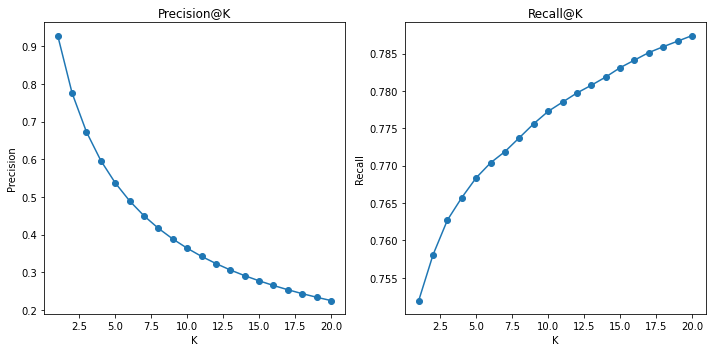

In [119]:
precision_data = table_metrics[table_metrics['metric'].str.contains('precision')]
recall_data = table_metrics[table_metrics['metric'].str.contains('recall')]


precision_mean = precision_data['mean']
recall_mean = recall_data['mean']

precision_k = [int(x.split('@')[-1]) for x in precision_data['metric']]
recall_k = [int(x.split('@')[-1]) for x in recall_data['metric']]


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(precision_k, precision_mean, marker='o')
plt.title('Precision@K')
plt.xlabel('K')
plt.ylabel('Precision')

plt.subplot(1, 2, 2)
plt.plot(recall_k, recall_mean, marker='o')
plt.title('Recall@K')
plt.xlabel('K')
plt.ylabel('Recall')

plt.tight_layout()
plt.show()

In [123]:
import numpy as np

def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.

def ndcg_at_k(r, k):
    dcg_max = dcg_at_k(sorted(r, reverse=True), k)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k) / dcg_max

def ndcg_at_all_ks(r, ks):
    ndcgs = []
    for k in ks:
        ndcgs.append(ndcg_at_k(r, k))
    return ndcgs

def ndcg_for_predictions(masked_basket, preds, original_basket, ks):
    masked_and_preds = masked_basket.copy()
    ndcgs = []
    for k in ks:
        masked_preds = preds[:k]
        masked_and_preds.extend(masked_preds)
        relevance = [1 if item in original_basket else 0 for item in masked_and_preds]
        ndcgs.append(ndcg_at_k(relevance, k))
    return ndcgs

In [124]:
def calculate_and_save_ndcg(df, ks):
    for index, row in df.iterrows():
        original_basket = row['original_basket']
        masked_basket = row['masked_basket']
        preds = row['preds']
        
        ndcgs = ndcg_for_predictions(masked_basket, preds, original_basket, ks)
        
        for k, ndcg in zip(ks, ndcgs):
            df.at[index, f'ndcg@{k}'] = ndcg

In [128]:
calculate_and_save_ndcg(evaluation_df, ks = [1,2,3,4,5,6,7,8,10])

Second option: we saved the amount of masked items when creating a masked test sample --> the гипотеза такая что we should check the precision and recall @ k with additional paramemter as the num of masked items and to check that the items to pred are surely were suggested in predicted recommendations

In [66]:
evaluation_df_data_tables

,order_id,original_basket,num_to_mask,masked_basket,vector,recs,preds
0,300652850781,"[647, 73255, 42672]",1,"[647, 73255]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[9, 93, 67, 151, 480, 3030, 546, 80, 1404, 48...","[647, 731, 173, 76719, 76709, 61986, 49623, 33..."
1,300652850783,"[33142, 72133, 647, 59318]",1,"[647, 72133, 59318]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[9, 1117, 6402, 67, 1770, 546, 409, 1803, 326...","[647, 59310, 79165, 173, 24910, 49623, 185, 56..."
2,300652850784,"[647, 47115, 1642, 69937]",1,"[647, 47115, 1642]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[9, 67, 93, 122, 407, 410, 546, 966, 532, 419...","[647, 173, 731, 605, 14526, 17525, 49623, 3629..."
3,300652850787,"[63727, 18291, 34804, 647, 36871, 63032, 48473...",2,"[64579, 63727, 36871, 48473, 647, 18291, 42530...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[9, 93, 546, 1910, 497, 1918, 1909, 67, 206, ...","[647, 731, 49623, 18518, 19434, 17823, 75717, ..."
4,300652850789,"[647, 16591, 73541, 83219, 68678, 85386, 89167]",2,"[89167, 83219, 85386, 647, 73541]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[9, 878, 93, 667, 67, 307, 1098, 966, 206, 20...","[647, 488, 731, 16306, 173, 47467, 273, 36296,..."
...,...,...,...,...,...,...,...
6821,300652862092,"[61013, 23025, 52515, 73783, 25290, 647, 27834]",2,"[647, 73783, 25290, 52515, 23025]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[9, 1387, 93, 67, 80, 660, 1746, 414, 878, 96...","[647, 76598, 731, 173, 33154, 20665, 30084, 82..."
6822,300652862093,"[33572, 32680, 647, 20038, 30155, 22297]",2,"[22297, 30155, 647, 32680]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[9, 20, 67, 80, 93, 465, 1179, 592, 966, 546,...","[647, 609, 173, 33154, 731, 21270, 29851, 143,..."
6823,300652862094,"[173, 65511, 74946, 60900, 647]",1,"[74946, 60900, 65511, 173]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[9, 110, 592, 91, 108, 20, 417, 2024, 3749, 4...","[647, 158, 143, 22658, 77532, 609, 16645, 1696..."
6824,300652862095,"[51223, 22659, 77201, 67270, 647, 75440]",2,"[51223, 647, 77201, 22659]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[9, 67, 56, 811, 93, 20, 607, 3859, 550, 1143...","[647, 173, 65301, 1713, 731, 609, 58728, 36126..."


In [67]:
def precision_recall_at_fixed_masked_k(masked_basket, preds, original_basket, masked_k):
    precision = []
    recall = []
    masked_and_preds = masked_basket.copy()
    k = 0
    while k < len(preds) and len(masked_and_preds) < masked_k:
        # check if prediction is already in masked_basket
        if preds[k] not in masked_and_preds:
            masked_and_preds.append(preds[k])  # Add prediction to masked basket only if it's not already there
        intersection = len(set(masked_and_preds).intersection(set(original_basket)))
        precision.append(intersection / len(masked_and_preds))
        recall.append(intersection / len(original_basket))
        k += 1
    return precision, recall

In [93]:
def calculate_fixed_k_metrics(df):
    for index, row in evaluation_df.iterrows():
        original_basket = row['original_basket']
        masked_basket = row['masked_basket']
        preds = row['preds']
        masked_k = row['num_to_mask']

        precisions, recalls = precision_recall_at_fixed_masked_k(masked_basket, preds, original_basket, masked_k)
        for k, (precision, recall) in enumerate(zip(precisions, recalls), start=1):
            df.at[index, f'precision@{k}'] = precision
            df.at[index, f'recall@{k}'] = recall

In [94]:
calculate_fixed_k_metrics(evaluation_df_data_tables)

In [95]:
evaluation_df_data_tables.head()

,order_id,original_basket,num_to_mask,masked_basket,vector,recs,preds,precision@1,recall@1,precision@2,...,precision@16,recall@16,precision@17,recall@17,precision@18,recall@18,precision@19,recall@19,precision@20,recall@20
0,300652850781,"[647, 73255, 42672]",1,"[647, 73255]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[9, 93, 67, 151, 480, 3030, 546, 80, 1404, 48...","[647, 731, 173, 76719, 76709, 61986, 49623, 33...",1.0,0.666667,0.666667,...,0.117647,0.666667,0.111111,0.666667,0.105263,0.666667,0.100000,0.666667,0.095238,0.666667
1,300652850783,"[33142, 72133, 647, 59318]",1,"[647, 72133, 59318]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[9, 1117, 6402, 67, 1770, 546, 409, 1803, 326...","[647, 59310, 79165, 173, 24910, 49623, 185, 56...",1.0,0.750000,0.750000,...,0.166667,0.750000,0.157895,0.750000,0.150000,0.750000,0.142857,0.750000,0.136364,0.750000
2,300652850784,"[647, 47115, 1642, 69937]",1,"[647, 47115, 1642]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[9, 67, 93, 122, 407, 410, 546, 966, 532, 419...","[647, 173, 731, 605, 14526, 17525, 49623, 3629...",1.0,0.750000,0.750000,...,0.166667,0.750000,0.157895,0.750000,0.150000,0.750000,0.142857,0.750000,0.136364,0.750000
3,300652850787,"[63727, 18291, 34804, 647, 36871, 63032, 48473...",2,"[64579, 63727, 36871, 48473, 647, 18291, 42530...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[9, 93, 546, 1910, 497, 1918, 1909, 67, 206, ...","[647, 731, 49623, 18518, 19434, 17823, 75717, ...",1.0,0.800000,0.888889,...,0.347826,0.800000,0.333333,0.800000,0.320000,0.800000,0.307692,0.800000,0.296296,0.800000
4,300652850789,"[647, 16591, 73541, 83219, 68678, 85386, 89167]",2,"[89167, 83219, 85386, 647, 73541]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[9, 878, 93, 667, 67, 307, 1098, 966, 206, 20...","[647, 488, 731, 16306, 173, 47467, 273, 36296,...",1.0,0.714286,0.833333,...,0.300000,0.857143,0.285714,0.857143,0.272727,0.857143,0.260870,0.857143,0.250000,0.857143


In [96]:
# evaluation_df_data_tables.loc[2]

In [97]:
evaluation_df_data_tables.describe()

table_metrics = evaluation_df_data_tables.describe().T.reset_index().rename({'index': 'metric'}, axis = 1)
table_metrics = table_metrics[['metric', 'mean', 'std']].drop(index = [0,1])

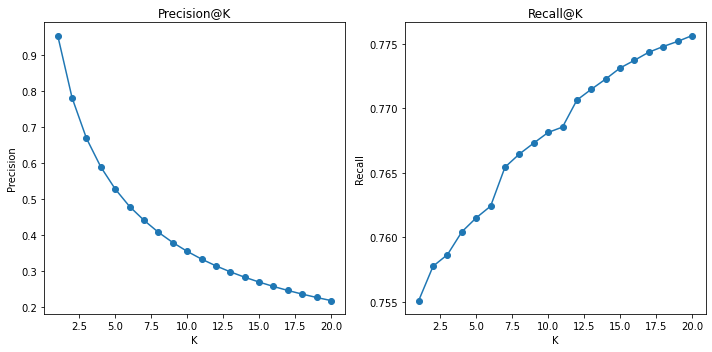

In [98]:
precision_data = table_metrics[table_metrics['metric'].str.contains('precision')]
recall_data = table_metrics[table_metrics['metric'].str.contains('recall')]


precision_mean = precision_data['mean']
recall_mean = recall_data['mean']

precision_k = [int(x.split('@')[-1]) for x in precision_data['metric']]
recall_k = [int(x.split('@')[-1]) for x in recall_data['metric']]


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(precision_k, precision_mean, marker='o')
plt.title('Precision@K')
plt.xlabel('K')
plt.ylabel('Precision')

plt.subplot(1, 2, 2)
plt.plot(recall_k, recall_mean, marker='o')
plt.title('Recall@K')
plt.xlabel('K')
plt.ylabel('Recall')

plt.tight_layout()
plt.show()

In [99]:
def calculate_fixed_k_metrics_top_n(df):
    for index, row in evaluation_df.iterrows():
        original_basket = row['original_basket']
        masked_basket = row['masked_basket']
        preds = list_of_top_n
        masked_k = row['num_to_mask']

        precisions, recalls =precision_recall_at_fixed_masked_k(masked_basket, preds, original_basket, masked_k)
        for k, (precision, recall) in enumerate(zip(precisions, recalls), start=1):
            df.at[index, f'precision@{k}'] = precision
            df.at[index, f'recall@{k}'] = recall

In [100]:
calculate_precision_recall_top_n_items(evaluation_df_data_tables,top_rec_items)

In [102]:
# evaluation_df_data_tables

Top-N items scores: 

Would recommeding most popular items win vs EASE? 

In [79]:
top_rec_items = train_data.good_foreign_id.value_counts()[:20].index.tolist()

In [80]:
train_data.good_foreign_id.value_counts(normalize = True)

647      0.126118
731      0.009941
609      0.005102
173      0.004648
22658    0.004423
           ...   
74334    0.000002
91525    0.000002
74341    0.000002
54314    0.000002
75977    0.000002
Name: good_foreign_id, Length: 10452, dtype: float64

In [81]:
tt = pd.DataFrame(train_data.groupby(['order_id']).agg(list).good_foreign_id).reset_index()

In [82]:
def has_647(row):
    return 647 in row['good_foreign_id']

filtered_df = tt.loc[tt.apply(has_647, axis=1)]

len(filtered_df) / len(tt)

0.9297072411240715

In [83]:
evaluation_df_data_tables.head()

,order_id,original_basket,num_to_mask,masked_basket,vector,recs,preds
0,300652850781,"[647, 73255, 42672]",1,"[647, 73255]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[9, 93, 67, 151, 480, 3030, 546, 80, 1404, 48...","[647, 731, 173, 76719, 76709, 61986, 49623, 33..."
1,300652850783,"[33142, 72133, 647, 59318]",1,"[647, 72133, 59318]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[9, 1117, 6402, 67, 1770, 546, 409, 1803, 326...","[647, 59310, 79165, 173, 24910, 49623, 185, 56..."
2,300652850784,"[647, 47115, 1642, 69937]",1,"[647, 47115, 1642]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[9, 67, 93, 122, 407, 410, 546, 966, 532, 419...","[647, 173, 731, 605, 14526, 17525, 49623, 3629..."
3,300652850787,"[63727, 18291, 34804, 647, 36871, 63032, 48473...",2,"[64579, 63727, 36871, 48473, 647, 18291, 42530...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[9, 93, 546, 1910, 497, 1918, 1909, 67, 206, ...","[647, 731, 49623, 18518, 19434, 17823, 75717, ..."
4,300652850789,"[647, 16591, 73541, 83219, 68678, 85386, 89167]",2,"[89167, 83219, 85386, 647, 73541]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[9, 878, 93, 667, 67, 307, 1098, 966, 206, 20...","[647, 488, 731, 16306, 173, 47467, 273, 36296,..."


In [84]:
def calculate_precision_recall_top_n_items(df, list_of_top_n):
    for index, row in df.iterrows():
        original_basket = row['original_basket']
        masked_basket = row['masked_basket']
        preds = list_of_top_n #top_item_list 
        
        precisions, recalls = precision_recall_at_k(masked_basket, preds, original_basket)
        
        for k, (precision, recall) in enumerate(zip(precisions, recalls), start=1):
            df.at[index, f'precision@{k}'] = precision
            df.at[index, f'recall@{k}'] = recall

In [85]:
calculate_precision_recall_top_n_items(evaluation_df_data_tables,top_rec_items )

In [86]:
evaluation_df_data_tables.head(3)

,order_id,original_basket,num_to_mask,masked_basket,vector,recs,preds,precision@1,recall@1,precision@2,...,precision@16,recall@16,precision@17,recall@17,precision@18,recall@18,precision@19,recall@19,precision@20,recall@20
0,300652850781,"[647, 73255, 42672]",1,"[647, 73255]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[9, 93, 67, 151, 480, 3030, 546, 80, 1404, 48...","[647, 731, 173, 76719, 76709, 61986, 49623, 33...",1.0,0.666667,0.666667,...,0.117647,0.666667,0.111111,0.666667,0.105263,0.666667,0.100000,0.666667,0.095238,0.666667
1,300652850783,"[33142, 72133, 647, 59318]",1,"[647, 72133, 59318]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[9, 1117, 6402, 67, 1770, 546, 409, 1803, 326...","[647, 59310, 79165, 173, 24910, 49623, 185, 56...",1.0,0.750000,0.750000,...,0.166667,0.750000,0.157895,0.750000,0.150000,0.750000,0.142857,0.750000,0.136364,0.750000
2,300652850784,"[647, 47115, 1642, 69937]",1,"[647, 47115, 1642]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[9, 67, 93, 122, 407, 410, 546, 966, 532, 419...","[647, 173, 731, 605, 14526, 17525, 49623, 3629...",1.0,0.750000,0.750000,...,0.166667,0.750000,0.157895,0.750000,0.150000,0.750000,0.142857,0.750000,0.136364,0.750000


In [87]:
table_metrics = evaluation_df_data_tables.describe().T.reset_index().rename({'index': 'metric'}, axis = 1)

In [88]:
table_metrics = table_metrics[['metric', 'mean', 'std']].drop(index = [0,1])

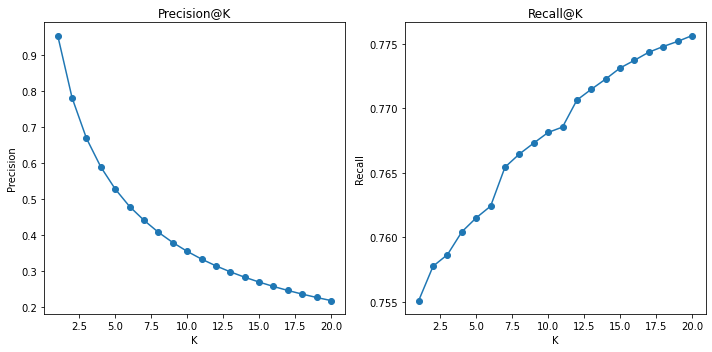

In [89]:
precision_data = table_metrics[table_metrics['metric'].str.contains('precision')]
recall_data = table_metrics[table_metrics['metric'].str.contains('recall')]


precision_mean = precision_data['mean']
recall_mean = recall_data['mean']

precision_k = [int(x.split('@')[-1]) for x in precision_data['metric']]
recall_k = [int(x.split('@')[-1]) for x in recall_data['metric']]


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(precision_k, precision_mean, marker='o')
plt.title('Precision@K')
plt.xlabel('K')
plt.ylabel('Precision')

plt.subplot(1, 2, 2)
plt.plot(recall_k, recall_mean, marker='o')
plt.title('Recall@K')
plt.xlabel('K')
plt.ylabel('Recall')

plt.tight_layout()
plt.show()